# Spam Classification Test

## Setup

In [1]:
# Data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nltk.stem import SnowballStemmer # Stemmer
from nltk.corpus import stopwords # Removes Stopwords
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# Learning
from sklearn.feature_extraction.text import TfidfVectorizer

# Other Imports
import string

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sms-spam-collection-dataset/spam.csv


## Preprocessing
### Read Data

In [2]:
data = pd.read_csv("../input/sms-spam-collection-dataset/spam.csv",encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Edit Csv
1. Remove unneccessary columns
2. Rename columns

In [3]:
# 1
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

# 2
data = data.rename(columns = {"v1":"type", "v2":"text"})
data.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Visualize Data

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

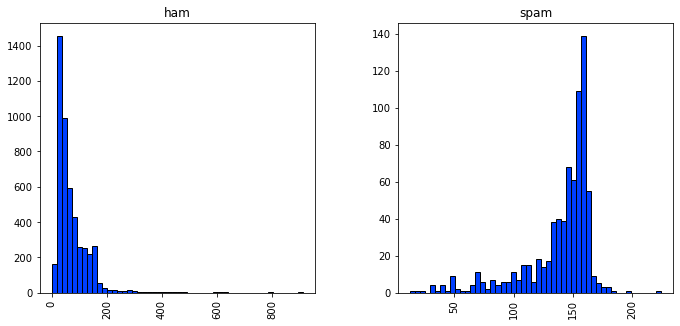

In [4]:
# Add column "length"
data['length'] = data['text'].apply(len)

# Configure graph
mpl.rcParams["patch.force_edgecolor"] = True
plt.style.use("seaborn-bright")

# Show Graph
data.hist(column='length', by='type', bins=50,figsize=(11,5))

### Preprocess Text & Vectorize
1. Remove punctuation
2. Remove stopwords
3. Convert to lowercase
4. Stomp words

In [5]:
def preprocess(text):
    # 1
    text = text.translate(str.maketrans("", "", string.punctuation))
    # 2 & 3
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    words = ""
    for c in text:
        # 4
        stemmer = SnowballStemmer("english")
        words += (stemmer.stem(c)) + " "
    
    return words

1. Apply preprocessing 
2. Split data into "test" and "train" subsets
3. Fit Training-Data (avoid Data-Leak!)
4. Transform all Data

In [6]:
# 1
preprocessed_text = data["text"].copy()
preprocessed_text = preprocessed_text.apply(preprocess)

# 2
features_train, features_test, labels_train, labels_test = train_test_split(preprocessed_text, data["type"], test_size=0.3, random_state=111)

# 3
vectorizer = TfidfVectorizer("english")
vectorizer.fit(features_train)

# 4
features_train = vectorizer.transform(features_train)
features_test = vectorizer.transform(features_test)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass input=english as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


### Train Model
1. Initialize Kernel
2. Fit training features and labels
3. Check model accuracy

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# 1
svc = SVC(kernel="sigmoid", gamma = 1.0)
# 2
svc.fit(features_train, labels_train)
# 3
prediction = svc.predict(features_test)
accuracy_score(labels_test, prediction)

0.9820574162679426

### Train more models
(Based on [this notebook](https://www.kaggle.com/muzzzdy/sms-spam-detection-with-various-classifiers))

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

In [9]:
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

Create list of classifiers and iterate through them

In [10]:
classifiers = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

In [11]:
predictions = []
for name, classifier in classifiers.items():
    classifier.fit(features_train, labels_train)
    prediction = classifier.predict(features_test)
    predictions.append((name, accuracy_score(labels_test, prediction)))

Output scores as table

In [12]:
dataframe = pd.DataFrame.from_records(predictions, index="Classifier", columns=["Classifier", "Score"])
dataframe

,Score
Classifier,
SVC,0.982057
KN,0.929426
NB,0.988038
DT,0.950957
LR,0.947967
RF,0.976077
AdaBoost,0.965909
BgC,0.962919
ETC,0.977273


Visualize Data

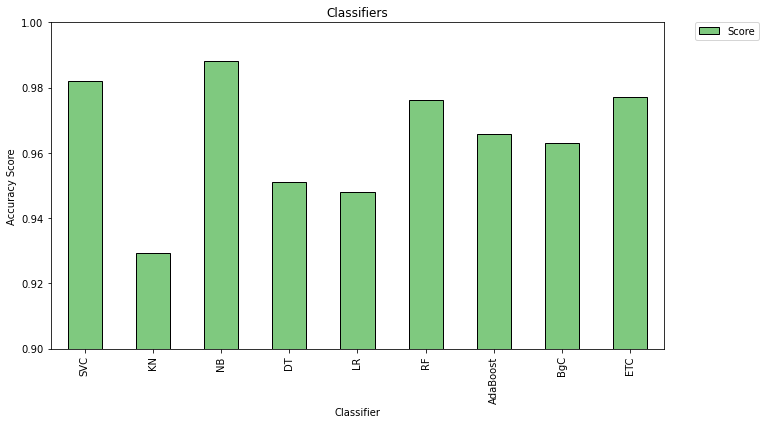

In [13]:
dataframe.plot(kind="bar", ylim=(0.9,1.0), figsize=(11,6), align="center", colormap="Accent")
plt.xticks(np.arange(9), dataframe.index)
plt.ylabel("Accuracy Score")
plt.title("Classifiers")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)